In [1]:
from __future__ import division

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/spatial/__init__.py:96: ImportWarning: Not importing directory '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/spatial/qhull': missing __init__.py
  from .qhull import *
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/optimize/_minimize.py:37: ImportWarning: Not importing directory '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/optimize/lbfgsb': missing __init__.py
  from .lbfgsb import _minimize_lbfgsb


## setup

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.pyc'>

In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['graphical_conventions']

# which iteration name should we use?
iterationName = 'run1_chairsOnly'

In [4]:
## get total number of stroke and clickedObj events in the collection as a whole
S = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'stroke'}]}).sort('time')
C = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}]}).sort('time')
print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.'

987 stroke records in the database.
280 clickedObj records in the database.


## generate group dataframe

In [5]:
## list of researcher mturk worker ID's to ignore
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
megsano = ['A1DVQQLVZR7W6I']
researchers = jefan + hawkrobe + megsano

In [6]:
## get list of all candidate games
games = coll.distinct('gameid')

## get list of complete and valid games
complete_games = h.get_complete_and_valid_games(games,coll,researchers=researchers, tolerate_undefined_worker=False)

There was something wrong with this game 2306-68150396-3082-458b-bf35-5683428df704
There was something wrong with this game 2909-8200b9a1-435f-4c08-b71b-04bd71508910
There are 16 complete games in total.


In [26]:
reload(h)

# preprocessing 

TrialNum = []
GameID = []
Condition = []
Target = []
Category = []
Distractor1 = []
Distractor2 = []
Distractor3 = []
Outcome = []
Response = []
Repetition = []
Phase = []
numStrokes = []
drawDuration = [] # in seconds
svgStringLength = [] # sum of svg string for whole sketch
svgStringLengthPerStroke = [] # svg string length per stroke
numCurvesPerSketch = [] # number of curve segments per sketch
numCurvesPerStroke = [] # mean number of curve segments per stroke
svgStringStd = [] # std of svg string length across strokes for this sketch
Outcome = [] #accuracy (True or False)
png=[] # the sketch 
timedOut=[] # True if sketchers didn't draw anything, False o.w.
meanPixelIntensity=[]

_complete_games = complete_games[9:]
_complete_games=['9586-18f615d7-d91a-4699-a5ad-99db292aefae', '1459-053ba57b-1d00-4086-8e75-c67d5cd3d723', 
                 '2971-f7dd52e0-7382-49f8-abd1-b8319cd57b5c', '6832-ec429141-c034-4586-9627-ea99e268e265',
                 '1275-95ce2242-ec22-4968-b824-7c853ac1afbf'] # run1_chairsOnly 
#'4634-81e74942-d2cb-4c13-bbca-2c9b4bef5c7a', removed because of multiple timeouts 

for i,g in enumerate(_complete_games):
        print 'Analyzing game {} | {} of {}: '.format(g, i, len(complete_games))

        # collection of all clickedObj events in a particular game 
        X = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}]}).sort('time')
        # collection of all stroke events in a particular game 
        Y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}]}).sort('time')

        for t in X: # for each clickedObj event
            targetname = t['intendedName']
            category = h.OBJECT_TO_CATEGORY[targetname]
            Phase.append(t['phase'])
            Repetition.append(t['repetition'])
            distractors = [t['object2Name'],t['object3Name'],t['object4Name']]
            full_list = [t['intendedName'],t['object2Name'],t['object3Name'],t['object4Name']] 
            png.append(t['pngString'])

            #for each stroke event with same trial number as this particular clickedObj event 
            y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
            # have to account for cases in which sketchers do not draw anything 
            if (y.count() == 0):
                numStrokes.append(float('NaN'))
                drawDuration.append(float('NaN'))
                svgStringLength.append(float('NaN'))
                svgStringLengthPerStroke.append(float('NaN'))
                numCurvesPerSketch.append(float('NaN'))
                numCurvesPerStroke.append(float('NaN'))
                svgStringStd.append(float('NaN'))
                meanPixelIntensity.append('NaN')
                timedOut.append(True)
            else: 
                # calculate numStrokes 
                lastStrokeNum = float(y[y.count() - 1]['currStrokeNum']) # get currStrokeNum at last stroke
                numStrokes.append(lastStrokeNum)
                
                # calculate drawDuration 
                startStrokeTime =  float(y[0]['startStrokeTime'])
                endStrokeTime = float(y[y.count() - 1]['endStrokeTime']) ## took out negative 1 
                duration = (endStrokeTime - startStrokeTime) / 1000
                drawDuration.append(duration)
                
                # calculate other measures that have to do with sketch 
                ls = [len(_y['svgData']) for _y in y]
                svgStringLength.append(sum(ls))
                y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')            
                num_curves = [len([m.start() for m in re.finditer('c',str(_y['svgData']))]) for _y in y] ## gotcha: need to call string on _y['svgData'], o/w its unicode and re cant do anything with it
                numCurvesPerSketch.append(sum(num_curves))
                numCurvesPerStroke.append(sum(num_curves)/lastStrokeNum)
                svgStringLengthPerStroke.append(sum(ls)/lastStrokeNum)
                svgStringStd.append(np.std(ls))
                timedOut.append(False)
                
                ## calculate pixel intensity (amount of ink spilled) 
            
                imsize = 100
                numpix = imsize**2
                thresh = 250
                imgData = t['pngString']
                filestr = base64.b64decode(imgData)
                fname = os.path.join('sketch.png')
                with open(fname, "wb") as fh:
                    fh.write(imgData.decode('base64'))
                im = Image.open(fname).resize((imsize,imsize))
                _im = np.array(im)
                meanPixelIntensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)

            ### aggregate game metadata
            TrialNum.append(t['trialNum'])
            GameID.append(t['gameid'])        
            Target.append(targetname)
            Category.append(category)
            Condition.append(t['condition'])
            Response.append(t['clickedName'])
            Outcome.append(t['correct'])
            Distractor1.append(distractors[0])
            Distractor2.append(distractors[1])
            Distractor3.append(distractors[2])  

Analyzing game 9586-18f615d7-d91a-4699-a5ad-99db292aefae | 0 of 16: 
Analyzing game 1459-053ba57b-1d00-4086-8e75-c67d5cd3d723 | 1 of 16: 
Analyzing game 2971-f7dd52e0-7382-49f8-abd1-b8319cd57b5c | 2 of 16: 
Analyzing game 6832-ec429141-c034-4586-9627-ea99e268e265 | 3 of 16: 
Analyzing game 1275-95ce2242-ec22-4968-b824-7c853ac1afbf | 4 of 16: 


In [10]:
## now actually make dataframe
GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity, svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png = map(np.array, \
[GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity,svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut,png])    

Repetition = map(int,Repetition)

D = pd.DataFrame([GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity,svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png], 
                 index = ['gameID','trialNum','condition', 'target', 'category', 'repetition', 'phase', 'drawDuration', 'outcome', 'response', 'numStrokes', 'meanPixelIntensity', 'svgStringLength', 'svgStringLengthPerStroke', 'svgStringStd', 'numCurvesPerSketch', 'numCurvesPerStroke', 'timedOut', 'png'])
D = D.transpose()

## save out dataframe to be able to load in and analyze later w/o doing the above mongo querying ...
D.to_csv(os.path.join(results_dir,'graphical_conventions_group_data_{}.csv'.format(iterationName)))

# Just look at one game 
#D = D[D['gameID'] == '1180-2832f7d7-535a-4fb3-acf4-d40972f6d878']

# Just look at repeated trials and sort them by target and reps 
# _D = D[(D.condition=='repeated')]
# _D = _D.sort_values(by=['target','repetition'])
D

,gameID,trialNum,condition,target,category,repetition,phase,drawDuration,outcome,response,numStrokes,meanPixelIntensity,svgStringLength,svgStringLengthPerStroke,svgStringStd,numCurvesPerSketch,numCurvesPerStroke,timedOut,png
0,9586-18f615d7-d91a-4699-a5ad-99db292aefae,1,repeated,sling,chair,0,pre,13.192,False,waiting,8,0.0315,776,97,39.1088,21,2.625,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
1,9586-18f615d7-d91a-4699-a5ad-99db292aefae,2,control,woven,chair,0,pre,8.638,True,woven,7,0.0382,612,87.4286,46.6747,16,2.28571,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
2,9586-18f615d7-d91a-4699-a5ad-99db292aefae,3,repeated,waiting,chair,0,pre,3.927,True,waiting,3,0.0191,238,79.3333,2.86744,6,2,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
3,9586-18f615d7-d91a-4699-a5ad-99db292aefae,4,repeated,leather,chair,0,pre,5.163,True,leather,5,0.0287,383,76.6,34.4709,9,1.8,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
4,9586-18f615d7-d91a-4699-a5ad-99db292aefae,5,control,knob,chair,0,pre,5.964,True,knob,4,0.0284,518,129.5,157.907,13,3.25,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
5,9586-18f615d7-d91a-4699-a5ad-99db292aefae,6,repeated,inlay,chair,0,pre,2.756,True,inlay,2,0.0187,265,132.5,84.5,7,3.5,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
6,9586-18f615d7-d91a-4699-a5ad-99db292aefae,7,control,squat,chair,0,pre,11.272,True,squat,9,0.0389,515,57.2222,42.0787,13,1.44444,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
7,9586-18f615d7-d91a-4699-a5ad-99db292aefae,8,control,straight,chair,0,pre,4.806,True,straight,6,0.0196,260,43.3333,4.71405,6,1,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
8,9586-18f615d7-d91a-4699-a5ad-99db292aefae,9,repeated,sling,chair,1,repeated,5.7,True,sling,7,0.0364,847,121,73.1417,23,3.28571,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
9,9586-18f615d7-d91a-4699-a5ad-99db292aefae,10,repeated,inlay,chair,1,repeated,1.646,True,inlay,2,0.0172,311,155.5,66.5,8,4,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...


## visualize behavioral measures over time

In [24]:
# reload analysis_helpers just to be on the safe side 
reload(h)

## set seaborn style params here
sns.set_context('poster')
sns.set_style('white')

### plot time series during repetition phase 

##### individual measures across reps (repeated trials only)

In [16]:
# What is the measure that you want to visualize across reps? 
dv = 'meanPixelIntensity' 

In [17]:
# D0 = h.ts_repeated(D,
#                                     var=dv,
#                                     limit=10, # recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
#                                     save_plot=False,
#                                     plot_dir=plot_dir)

##### individual measures across reps (repeated + control)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


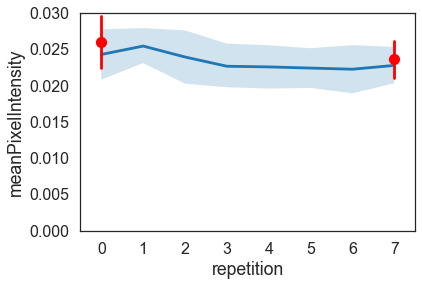

In [20]:
h.ts_repeated_control(D, 
                        var=dv,
                        limit=0.03, # recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
                        save_plot=False,
                        plot_dir=plot_dir)

##### 4 measures (2x2) across reps (repeated + control) 

In [22]:
# What are the four measures that you want to visualize across reps? 
var0='numStrokes'
var1='drawDuration'
var2='numCurvesPerSketch'
var3='numCurvesPerStroke'

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in 

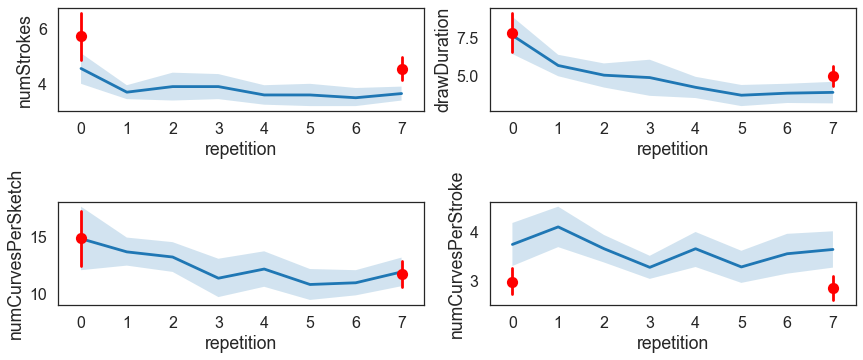

In [25]:
h.ts_grid_repeated_control(D, 
                                                var0, var1, var2, var3,
                                                 save_plot=False,
                                                 plot_dir=plot_dir)

### compare conditions in pre and post phases 

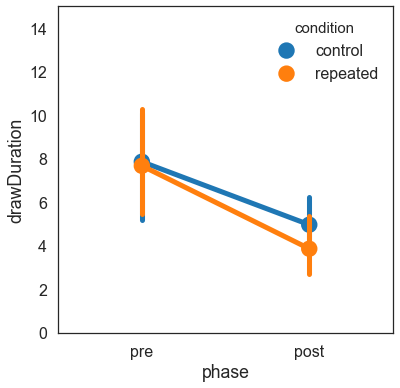

In [22]:
D1 = h.compare_conditions_prepost(D,
                                var=dv,
                                limit=15,
                                save_plot=False,
                                plot_dir=plot_dir)

 ### visualize how sketches are changing across repetitions

In [17]:
# print_repeated_sketches(D,
#                                      complete_games,
#                                      sketch_dir)

In [18]:
# print_control_sketches(D,
#                                    complete_games,
#                                    sketch_dir)

### WORKING AREA

In [ ]:
## collapsing across objects within repetition (within pair) 
D0_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var0].mean()).reset_index()
D1_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var1].mean()).reset_index()
D2_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var2].mean()).reset_index()
D3_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var3].mean()).reset_index()

D0_control = ((D_control.groupby(['gameID','repetition','condition'])[var0].mean()).reset_index()).replace(1, 7) # rescale control reps 
D1_control = ((D_control.groupby(['gameID','repetition','condition'])[var1].mean()).reset_index()).replace(1, 7) # rescale control reps 
D2_control = ((D_control.groupby(['gameID','repetition','condition'])[var2].mean()).reset_index()).replace(1, 7) # rescale control reps 
D3_control = ((D_control.groupby(['gameID','repetition','condition'])[var3].mean()).reset_index()).replace(1, 7) # rescale control reps 

In [ ]:

# sns.tsplot(data=D0_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var0,
#            ax=ax0)

# sns.tsplot(data=D0_control,
#                time='repetition',
#                unit='gameID',
#                value=var0,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax0,
#                color='r')

# sns.tsplot(data=D1_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var1,
#            ax=ax1)

# sns.tsplot(data=D1_control,
#                time='repetition',
#                unit='gameID',
#                value=var1,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax1,
#                color='r')

# sns.tsplot(data=D2_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var2,
#            ax=ax2)

# sns.tsplot(data=D2_control,
#                time='repetition',
#                unit='gameID',
#                value=var2,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax2,
#                color='r')

# sns.tsplot(data=D3_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var3,
#            ax=ax3)

# sns.tsplot(data=D3_control,
#                time='repetition',
#                unit='gameID',
#                value=var3,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax3,
#                color='r')

# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# ax0.set(xlim=(-0.5, 7.5), xticks=range(0,8))
# ax1.set(xlim=(-0.5, 7.5), xticks=range(0,8))
# ax2.set(xlim=(-0.5, 7.5), xticks=range(0,8))
# ax3.set(xlim=(-0.5, 7.5), xticks=range(0,8))

In [ ]:
# for i in range(0, 4):
#     var = 'var'+ i
#     print var
#     'D' + str(i) + '_' + condition = collapse_within_repetition(D, var, condition)

In [ ]:
def convert_numeric(X,column_id):
    ## make numeric types for aggregation
    X[column_id] = pd.to_numeric(X[column_id])
    return X

D = convert_numeric(convert_numeric(convert_numeric(convert_numeric(D,var0),var1),var2),var3) 

def collapse_within_repetition(D, var, condition):
    _D = D[D['condition']==condition]
    if condition == 'repeated':
        return (_D.groupby(['gameID','repetition','condition'])[var].mean()).reset_index()
    else: 
        return ((_D.groupby(['gameID','repetition','condition'])[var].mean()).reset_index()).replace(1,7)
    
def plot_repeated_control(D_repeated, D_control, var, ax):
    sns.tsplot(data=D_repeated,
           time='repetition',
           unit='gameID',
           value=var,
           ax=ax)

    sns.tsplot(data=D_control,
               time='repetition',
               unit='gameID',
               value=var,
               err_style='ci_bars',
               interpolate=False,
               ax=ax,
               color='r')
    
    ax.set(xlim=(-0.5, 7.5), xticks=range(0,8))

# Miscellaneous

In [ ]:
#seaborn plotting

d = pd.DataFrame()
numReps = 7
variable = 'numStrokes'
# repeated conditions 
criteria_repeated = (D['condition']=='repeated')
repeated = D[criteria_repeated] # get all repeated condition trials 
repeats = list(range(0, numReps)) # number of repeats
repeated_means = []
for rep in repeats:
    mean = ((repeated[(repeated['repetition'] == rep)])[variable]).mean()  # get mean across trials with same repetition number
    repeated_means.append(mean)

# control conditions 
criteria_control = (D['condition']=='control')
control = D[criteria_control] # get all control condition trials 
controls = [0, numReps - 1] # number of controls scaled up to total number of repeats 
control_means= []
for i in [0, 1]: # only 2 controls, but should scale up to numReps 
    mean = ((control[(control['repetition'] == i)])[variable]).mean() # get mean across trials with same repetition number
    control_means.append(mean)

d['numReps'] = repeats
d[variable] = repeated_means
#d['control'] = control_means
facet = sns.lmplot(data=d, x='numReps', y=variable, fit_reg=False)
# add error bars 

In [ ]:
print repeated_strokes.mean(), control_strokes.mean()
print repeated_svgLength.mean(), control_svgLength.mean()
print repeated_svgStd.mean(), control_svgStd.mean()
print repeated_svgLengthPS.mean(), control_svgLengthPS.mean()
print repeated_drawDuration.mean(), control_drawDuration.mean()
print repeated_accuracy.mean(), control_accuracy.mean()

NameError: name 'control_strokes' is not defined

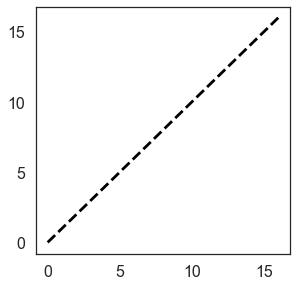

In [16]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
lb = 0
ub = 16
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_strokes,repeated_strokes,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('number of strokes')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,2)
lb = 0
ub = 3000
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgLength,repeated_svgLength,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg string length')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,3)
lb = 0
ub = 300
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgStd,repeated_svgStd,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('stroke variability')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,4)
lb = 0
ub = 600
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgLengthPS,repeated_svgLengthPS,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg length per stroke')
plt.xlabel('control')
plt.ylabel('repeated')

In [ ]:
a = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}, {'time':{'$gt':1531160581750, '$lt': 1531161932801}}]}).sort('time')
for rec in a:
    print rec['phase'], rec['condition'],rec['repetition']